# Linear Algebra

After `using LinearAlgebra`, **Julia speaks linear algebra fluently**.

Performing linear algebra operations on a computer is, of course, an old problem. Lots of amazing libraries have been written - mostly in Fortran - which have been optimized over decades.

Basically all high-level programming languages use these libraries, including R, Python, and Julia.

Linear algebra in Julia is largely implemented by calling [BLAS](http://www.netlib.org/blas/)/[LAPACK](http://www.netlib.org/lapack/) functions. Sparse operations utilize functionality in [SuiteSparse](http://faculty.cse.tamu.edu/davis/suitesparse.html).

As per default, Julia uses the [OpenBLAS](https://github.com/xianyi/OpenBLAS) implementation (BLAS, LAPACK, LIBM), which can be replaced by [Intel's MKL](https://software.intel.com/en-us/mkl) (BLAS, LAPACK) and [Intel's Math Library](https://software.intel.com/en-us/node/522653) (LIBM).

**What is all this stuff?!?**

* **BLAS**: a collection of low-level matrix and vector arithmetic operations ("multiply two matrices", "multiply a matrix by vector").
* **LAPACK**:  a collection of higher-level linear algebra operations. Things like matrix factorizations (LU, LLt, QR, SVD, Schur, etc) that are used to do things like “find the eigenvalues of a matrix”, or “find the singular values of a matrix”, or “solve a linear system”.
* **LIBM**: basic math functions like `sin`, `cos`, `sinh`, etcetera

Sparse matrices are more difficult and there exist different collections of routines, one of which is **SuiteSparse**.

**Why do I have to care?**

* Switching from OpenBLAS to MKL can give you large speedups!
* Since you might be leaving the world of Julia code, you loose easy inspectability and type genericity. The latter can be an issue for machine learning, as we'll discuss later in more detail.

# Taking linear algebra seriously

Julia is [taking linear algebra seriously](https://www.youtube.com/watch?v=C2RO34b_oPM)! (see [here](https://github.com/JuliaLang/julia/issues/4774), and [here](https://github.com/JuliaLang/julia/issues/20978)).

In [1]:
using LinearAlgebra

In [2]:
A = rand(4,4)

4×4 Matrix{Float64}:
 0.723449  0.474819  0.282224  0.13724
 0.849695  0.24294   0.816161  0.537401
 0.370268  0.511182  0.322675  0.608699
 0.706407  0.805153  0.557568  0.936108

In [3]:
typeof(A)

Matrix{Float64} (alias for Array{Float64, 2})

In [4]:
Array{Float64, 2} === Matrix{Float64} # equivalent not just equal

true

In [5]:
det(A)

-0.0049031709479690775

In [6]:
inv(A)

4×4 Matrix{Float64}:
 -2.84064  -2.24323  -42.1834   29.1337
  5.05385   1.31062   41.7085  -28.6141
  4.77736   4.60366   56.2057  -39.8907
 -5.04875  -2.17653  -37.5188   27.4543

In [7]:
rank(A)

4

Let's get a vector as well

In [8]:
v = rand(4)

4-element Vector{Float64}:
 0.6056190074664548
 0.3696125356924328
 0.7056722292644106
 0.8581696908398979

In [9]:
typeof(v)

Vector{Float64} (alias for Array{Float64, 1})

In [10]:
Array{Float64,1} === Vector{Float64}

true

In [11]:
norm(v)

1.3182626150266465

In [12]:
v^2 # can't square a vector

LoadError: MethodError: no method matching ^(::Vector{Float64}, ::Int64)
[0mClosest candidates are:
[0m  ^([91m::Union{AbstractChar, AbstractString}[39m, ::Integer) at /opt/julia-1.7.3/share/julia/base/strings/basic.jl:721
[0m  ^([91m::Complex{<:AbstractFloat}[39m, ::Integer) at /opt/julia-1.7.3/share/julia/base/complex.jl:839
[0m  ^([91m::Complex{<:Integer}[39m, ::Integer) at /opt/julia-1.7.3/share/julia/base/complex.jl:841
[0m  ...

In [13]:
v.^2

4-element Vector{Float64}:
 0.36677438220465386
 0.1366134265409899
 0.49797329515500294
 0.7364552182762459

Some things might be suprising

In [14]:
1/v

1×4 transpose(::Vector{Float64}) with eltype Float64:
 0.348494  0.212688  0.406068  0.493821

But if it works, there is typically meaning to it. In this case it is calculating the [Moore-Penrose-Pseudoinverse](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse#Vectors) (`transpose(v)/sum(abs2,v)`).

### Identity matrix: `UniformScaling` operator

In [15]:
A + 3

LoadError: MethodError: no method matching +(::Matrix{Float64}, ::Int64)
For element-wise addition, use broadcasting with dot syntax: array .+ scalar
[0mClosest candidates are:
[0m  +(::Any, ::Any, [91m::Any[39m, [91m::Any...[39m) at /opt/julia-1.7.3/share/julia/base/operators.jl:655
[0m  +([91m::T[39m, ::T) where T<:Union{Int128, Int16, Int32, Int64, Int8, UInt128, UInt16, UInt32, UInt64, UInt8} at /opt/julia-1.7.3/share/julia/base/int.jl:87
[0m  +([91m::T[39m, ::Integer) where T<:AbstractChar at /opt/julia-1.7.3/share/julia/base/char.jl:237
[0m  ...

In [16]:
A .+ 3

4×4 Matrix{Float64}:
 3.72345  3.47482  3.28222  3.13724
 3.84969  3.24294  3.81616  3.5374
 3.37027  3.51118  3.32267  3.6087
 3.70641  3.80515  3.55757  3.93611

The `UniformScaling` operator **represents an identity matrix of any size** and is another great example of **duck typing**. It automatically gets loaded into scope when you do `using LinearAlgebra` and has the name `I`.

In [17]:
I

UniformScaling{Bool}
true*I

Although it never actually materializes a full identity matrix it behaves like one.

In [18]:
A + 3I

4×4 Matrix{Float64}:
 3.72345   0.474819  0.282224  0.13724
 0.849695  3.24294   0.816161  0.537401
 0.370268  0.511182  3.32267   0.608699
 0.706407  0.805153  0.557568  3.93611

In [19]:
I * A == A

true

Hence, we can calculate things like, say, `A-b*I` without ever allocating a dense identity matrix, which would take up $\mathcal{O}(n^2)$ memory.

Let's benchmark the performance difference!

In [20]:
fullI = Matrix{Float64}(I, 4,4)

4×4 Matrix{Float64}:
 1.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0
 0.0  0.0  1.0  0.0
 0.0  0.0  0.0  1.0

In [21]:
fast(A) = A + 3 * I

fast (generic function with 1 method)

In [22]:
slow(A, fullI) = A .+ 3 .* fullI

slow (generic function with 1 method)

In [23]:
using BenchmarkTools
@btime slow($A, $fullI);
@btime fast($A);

  68.851 ns (1 allocation: 192 bytes)
  34.184 ns (1 allocation: 192 bytes)


# Fast linear algebra with multiple dispatch

##  Fermions hopping on a chain

$$\mathcal{H} = -t\sum_{\langle i,j \rangle} c_i^\dagger c_j + \mu \sum_i n_i$$

Here, $t$ is the hopping amplitude, $\mu$ is the chemical potential, and $c, c^\dagger$ are creation and annihilation operators.

For simplicity, we'll consider **open boundary conditions** (not periodic), in which case the Hamiltonian is tridiagonal.

Since the fermions are *not* interacting, we can work in the *single particle basis* and do not have to worry about how to construct a basis for the many-body Fock space.

We use the canonical cartesian basis in which one uses $0$s to indicate empty sites and a $1$ for the particle's site, i.e. $|00100\rangle$ represents the basis state which has the particle exclusively on the 3rd site.

If you aren't familiar with second quantization just think of $\mathcal{H}$ as any quantum mechanical operator that can be represented as a matrix.

----

**Our goal:** computing the energy expectation value, i.e. $\langle \psi | \mathcal{H} | \psi \rangle$.

First, let's build the Hamiltonian matrix.

In [24]:
N = 100 # number of sites
t = 1
μ = -0.5

H = diagm(0 => fill(μ, N), 1 => fill(-t, N-1), -1 => fill(-t, N-1))

100×100 Matrix{Float64}:
 -0.5  -1.0   0.0   0.0   0.0   0.0  …   0.0   0.0   0.0   0.0   0.0   0.0
 -1.0  -0.5  -1.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0  -1.0  -0.5  -1.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0  -1.0  -0.5  -1.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0  -1.0  -0.5  -1.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0  -1.0  -0.5  …   0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0  -1.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0  …   0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0


Let's further generate a random fake wave function.

In [25]:
ψ = normalize(rand(N)); # some state

Quantum mechanical energy expectation value:

In [26]:
E(H, ψ) = ψ'*H*ψ # <ψ|H|ψ>

E (generic function with 1 method)

In [27]:
E(H, ψ)

-1.9912084250057003

In [28]:
@btime E($H, $ψ);

  1.915 μs (1 allocation: 896 bytes)


So far, we aren't utilizing the structure of our Hamiltonian at all. Clearly, it has a lot of structure!

In [29]:
typeof(H)

Matrix{Float64} (alias for Array{Float64, 2})

Since our function `E(H, ψ)` is generic - we haven't restricted the input types nor are we assuming anything about types - we can change the type of `H` to utilize its structure and automagically speed up the computation.

First, let's utilize the sparsity of `H`, i.e. the fact that there are lots of zeros, by indicating it through a type.

In [30]:
using SparseArrays
Hsparse = sparse(H)

100×100 SparseMatrixCSC{Float64, Int64} with 298 stored entries:
⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦

In [31]:
@btime E($Hsparse, $ψ);

  369.639 ns (1 allocation: 896 bytes)


That's a solid **30x speedup**!

Looking more closely, our `H` isn't just sparse, but actually tridiagonal. Let's try to exploit that as well.

In [32]:
Htri = Tridiagonal(H)

100×100 Tridiagonal{Float64, Vector{Float64}}:
 -0.5  -1.0    ⋅     ⋅     ⋅     ⋅   …    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
 -1.0  -0.5  -1.0    ⋅     ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅   -1.0  -0.5  -1.0    ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅   -1.0  -0.5  -1.0    ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅   -1.0  -0.5  -1.0       ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅   -1.0  -0.5  …    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅   -1.0       ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   …    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅        ⋅     ⋅     ⋅     ⋅     ⋅     ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅        ⋅     ⋅    

In [33]:
@btime E($Htri, $ψ);

  169.033 ns (2 allocations: 944 bytes)


By choosing the type of `H` we are, through multiple dispatch, also choosing more efficient methods! Finding the best type (and therewith an algorithm) can sometimes be tricky and one has to play around a bit. The good thing is that it's very easy!

Note that there are also great matrix types available in the ecosystem, see [JuliaMatrices](https://github.com/JuliaMatrices), for example.

# Exact diagonalisation a.k.a Eigendecomposition

To diagonalize our dense "Hamiltonian", we simply call the built-in function `eigen`.

In [35]:
vals, vecs = eigen(H);

In [36]:
ψ0 = vecs[:,1]; # single-particle groundstate

In [37]:
E(H, ψ0)

-2.4990325645839753

In [38]:
E(H, ψ0) <= E(H, ψ) # groundstate has the lowest energy

true

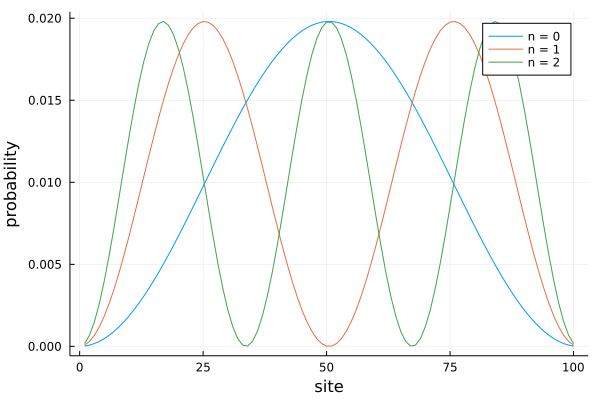

In [39]:
using Plots

show_n_states = 3

p = plot()
for i in 1:show_n_states
    plot!(p, abs2.(vecs[:,i]), xlab="site", ylab="probability", lab="n = $(i-1)")
end
p

Since Julia is using eigenproblem solvers from LAPACK (written in a low-level language) the code is, of course, **not generic**.

The best Julia can do, without implementing new functionality, is manually dispatch to the best LAPACK routine available.

Hence, it won't work with most of our special matrices.

In [40]:
eigen(Htri);

LoadError: MethodError: no method matching eigen!(::Tridiagonal{Float64, Vector{Float64}}; permute=true, scale=true, sortby=LinearAlgebra.eigsortby)
[0mClosest candidates are:
[0m  eigen!([91m::SymTridiagonal{var"#s861", V} where {var"#s861"<:Union{Float32, Float64}, V<:AbstractVector{var"#s861"}}[39m) at /opt/julia-1.7.3/share/julia/stdlib/v1.7/LinearAlgebra/src/tridiag.jl:284[91m got unsupported keyword arguments "permute", "scale", "sortby"[39m
[0m  eigen!([91m::SymTridiagonal{var"#s861", V} where {var"#s861"<:Union{Float32, Float64}, V<:AbstractVector{var"#s861"}}[39m, [91m::UnitRange[39m) at /opt/julia-1.7.3/share/julia/stdlib/v1.7/LinearAlgebra/src/tridiag.jl:287[91m got unsupported keyword arguments "permute", "scale", "sortby"[39m
[0m  eigen!([91m::SymTridiagonal{var"#s861", V} where {var"#s861"<:Union{Float32, Float64}, V<:AbstractVector{var"#s861"}}[39m, [91m::Real[39m, [91m::Real[39m) at /opt/julia-1.7.3/share/julia/stdlib/v1.7/LinearAlgebra/src/tridiag.jl:292[91m got unsupported keyword arguments "permute", "scale", "sortby"[39m
[0m  ...

If we're lucky, someone has implemented a generic solver in Julia that works for a wider range of types. Example:

In [41]:
Hbig = big.(H)
eigen(Hermitian(Hbig));

LoadError: MethodError: no method matching eigen!(::Hermitian{BigFloat, Matrix{BigFloat}}; sortby=nothing)
[0mClosest candidates are:
[0m  eigen!(::Union{Hermitian{T, S}, Hermitian{Complex{T}, S}, Symmetric{T, S}}, [91m::AbstractMatrix{T}[39m; sortby) where {T<:Number, S<:(StridedMatrix{T} where T)} at /opt/julia-1.7.3/share/julia/stdlib/v1.7/LinearAlgebra/src/symmetriceigen.jl:165
[0m  eigen!([91m::SymTridiagonal{var"#s861", V} where {var"#s861"<:Union{Float32, Float64}, V<:AbstractVector{var"#s861"}}[39m) at /opt/julia-1.7.3/share/julia/stdlib/v1.7/LinearAlgebra/src/tridiag.jl:284[91m got unsupported keyword argument "sortby"[39m
[0m  eigen!([91m::SymTridiagonal{var"#s861", V} where {var"#s861"<:Union{Float32, Float64}, V<:AbstractVector{var"#s861"}}[39m, [91m::UnitRange[39m) at /opt/julia-1.7.3/share/julia/stdlib/v1.7/LinearAlgebra/src/tridiag.jl:287[91m got unsupported keyword argument "sortby"[39m
[0m  ...

In [46]:
using GenericLinearAlgebra

In [47]:
eigen(Hermitian(Hbig));

Arguably the most important matrix type in science applications is a sparse matrix, i.e. `SparseMatrixCSC`.

In [48]:
eigen(Hsparse)

LoadError: eigen(A) not supported for sparse matrices. Use for example eigs(A) from the Arpack package instead.

Let's follow Julia's advice and take a look at [ARPACK.jl](https://github.com/JuliaLinearAlgebra/Arpack.jl) and similar packages.

### Diagonalizing sparse matrices

[ARPACK.jl]() -  Wrapper to Fortran library [ARPACK](https://www.caam.rice.edu/software/ARPACK/) which implements **iterative** eigenvalue and singular value solvers. By far the most established sparse eigensolver.

Julia implementations:

* [ArnoldiMethod.jl](https://github.com/haampie/ArnoldiMethod.jl)
* [KrylovKit.jl](https://github.com/Jutho/KrylovKit.jl)
* [IterativeSolvers.jl](https://github.com/JuliaMath/IterativeSolvers.jl)
* and more


A key thing to remember is that while `eigen` is - up to numerical errors - exact, the methods in the packages above are iterative and approximative.

Arpack uses a different name for the eigenvalue decomposition. They called it `eigs`.

In [51]:
using Arpack
λ, evs = eigs(Hsparse)

([-2.499032564583997, -2.4961311942671984, -2.491298695938046, -2.484539744726571, -2.4758608794815182, -2.4652704964445267], [-0.004376357346883243 0.00874848085072538 … -0.021797195856378005 -0.02611018880493217; -0.00874848085067608 0.017463115528582138 … -0.043068226575014114 -0.051313583714929265; … ; -0.008748480850739499 -0.017463115528548085 … -0.04306822657496766 0.0513135837149229; -0.004376357346915044 -0.008748480850708368 … -0.021797195856354732 0.026110188804928897], 6, 25, 334, [0.10152886694803813, -0.3073173836518221, -0.13808168248217428, 0.02192795334416142, 0.08647811793848889, -0.023839764809459305, 0.10424291749528851, -0.018245300549338504, -0.010734746198225974, 0.04966409679171471  …  -0.07942884899857107, -0.005011337046649324, 0.02345032480075343, 0.06206826648086016, -0.030976724739930385, 0.062544374665659, -0.0054016722352645125, -0.017326588567613387, -0.22047925445574962, 0.0829956537678384])

# Core messages of this Notebook

* The standard libraries `LinearAlgebra` and `SparseArrays` make Julia speak linear algebra.
* **Indicate properties and structure of a matrix**, like hermiticity or sparsity, through types. Fallback to generic types only if you run into method errors.
* For **sparse matrix exact diagonalization**, ARPACK.jl is sort of a standard but there are alternatives as well.